In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time

import tensorflow as tf

In [232]:
from IPython import display

In [182]:
url = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=url,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')
PATH

'/root/.keras/datasets/facades/'

In [183]:
buffer = 400
batch_size = 1
img_w = 256
img_h = 256
output_channels = 3

In [184]:
image = tf.io.read_file(PATH+'train/15.jpg')
print(type(image))
print(image)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\x00\x02\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijs

In [185]:
# image = tf.image.decode_jpeg(image)
# print(type(image))
# print(tf.shape(image))

In [186]:
def load(img_file):
  image = tf.io.read_file(img_file)
  image = tf.image.decode_jpeg(image) #to conv the img file from a jpeg, decode it to a uint8 tensor

  #acc to how the dataset is organized, (eg - 512 - 256+256 (real_img + input img(segmented)))

  group = tf.shape(image)[1]
  group = group // 2

  real_img = image[:, :group, :]
  input_img = image[:, group:, :]

  input_img = tf.cast(input_img, tf.float32)
  real_img = tf.cast(real_img, tf.float32)

  return input_img, real_img  

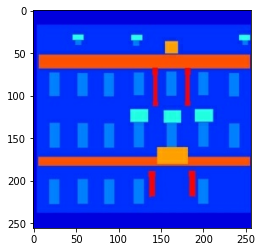

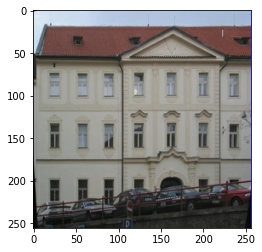

In [187]:
input, real = load(PATH+'train/15.jpg')

plt.figure()
plt.imshow(input/255.)

plt.figure()
plt.imshow(real/255.)

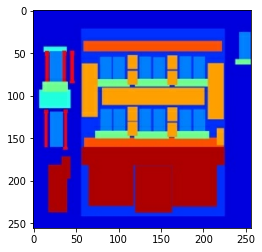

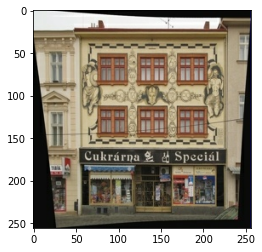

In [188]:
input, real = load(PATH+'train/75.jpg')

plt.figure()
plt.imshow(input/255.)

plt.figure()
plt.imshow(real/255.)

In [189]:
def resize(input_img, real_img, height, width):
  input_img = tf.image.resize(input_img, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  real_img = tf.image.resize(real_img, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_img, real_img

In [190]:
#random crop function to fix the size of the image to (256, 256)

def random_crop(input_img, real_img):
  stacked_img = tf.stack([input_img, real_img], axis = 0)
  cropped_img = tf.image.random_crop(stacked_img, size = [2, img_h, img_w, 3])

  return cropped_img[0], cropped_img[1] #input and real

In [191]:
#normalize to [-1, 1]

def normalize(input_img, real_img):
  input_img = (input_img / 127.5) - 1
  real_img = (real_img / 127.5) - 1

  return input_img, real_img

In [192]:
#In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256

#tf.func is used to make a callable which will enable the tf.graph to exec the func as a graph 

@tf.function()
def random_jitter(input_img, real_img):
  input_img, real_img = resize(input_img, real_img, 286, 286)
  input_img, real_img = random_crop(input_img, real_img)

  #for a varied dataset to train from , do a process of random mirroring

  if tf.random.uniform(()) > 0.4:
    input_img = tf.image.flip_left_right(input_img)
    real_img = tf.image.flip_left_right(real_img)


  return input_img, real_img  
  


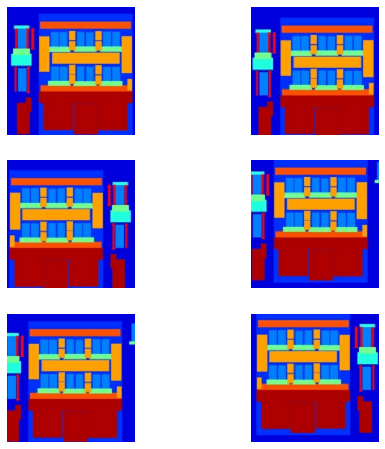

In [193]:
#use of the random jittering - resize to bigger by NN, crop randomly to target size, randomly flip the image

plt.figure(figsize = (8, 8))
for i in range(6):
  jittered_inp, jittered_real = random_jitter(input, real)
  plt.subplot(3, 2, i+1)
  plt.imshow(jittered_inp/255.0)
  plt.axis('off')

plt.show()  

In [194]:
def load_image_train(image_file):
  input_img, real_img = load(image_file)
  input_img, real_img = random_jitter(input_img, real_img)
  input_img, real_img = normalize(input_img, real_img)

  return input_img, real_img

#for the augmentation of train set images, we load jitter and normalize it  

In [195]:
#for the aug of test imgs, we load resize and normalize to pass into the model, no jitter since we arent training

def load_image_test(image_file):
  input_img, real_img = load(image_file)
  input_img, real_img = resize(input_img, real_img, img_h, img_w)
  input_img, real_img = normalize(input_img, real_img)

  return input_img, real_img

  

In [196]:
#here we use parallelism, set AUTOTUNE method of tf.data prefetching, a buffer is used to store the data fetched by
#a bg thread that runs to fetch certain elements, usually >= each batch size, which value is tuned using AUTOTUNE
#reduce the memory footprint by using shuffle with a buffer etc

#To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files:

train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer)
train_dataset = train_dataset.batch(batch_size)


In [197]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(batch_size)


Generator

   - The architecture of generator is a modified U-Net.
   - Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
   - Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)

   - There are skip connections between the encoder and decoder (as in U-Net).


In [198]:
def downsample(filters, size, batchnorm = True):  #encoder

  w_init = tf.random_normal_initializer(0.0, 0.02)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer= w_init, use_bias=False))

  if batchnorm:
    model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.LeakyReLU())

  return model

In [199]:
print(input.shape)
downsampling_model = downsample(3, 4)
downsampled_result = downsampling_model(tf.expand_dims(input, 0))
print(downsampled_result.shape)
#downsampling - ((N-F)/S + 1), here size of 4 is a 4x4 filter, SAME PADDING WILL MAKE THE DIMS +2 ON EACH AXIS DURING CONV IN UP AND DOWN

(256, 256, 3)
(1, 128, 128, 3)


In [200]:
def upsample(filters, size, dropout = False):  #decoder 

  w_init = tf.random_normal_initializer(0.0, 0.02)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer= w_init, use_bias=False))

  if dropout:
    model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.ReLU())

  return model

In [201]:
upsampling_model = upsample(3, 4)
upsampled_result = upsampling_model(downsampled_result)
print(upsampled_result.shape)

(1, 256, 256, 3)


In [202]:
def Generator():
  input = tf.keras.layers.Input(shape = [256, 256, 3])

  encoder = [
             downsample(64, 4, batchnorm = False), #(batch, 128, 128, 64)
             downsample(128, 4), #(batch, 64, 64, 128)
             downsample(256, 4), #(batch, 32, 32, 256)
             downsample(512, 4), #(batch, 16, 16, 512)
             downsample(512, 4), #(batch, 8, 8, 512)
             downsample(512, 4), 
             downsample(512, 4), 
             downsample(512, 4) #(batch, 1, 1, 512)
  ]

    #decoder uses relu activations and has dropout in first 3 layers

  decoder =   [  
            upsample(512, 4, dropout=True), # (batch, 8, 8, 1024)
            upsample(512, 4, dropout=True), # (batch, 2, 2, 1024)  
            upsample(512, 4, dropout=True), # (batch, 4, 4, 1024)
            upsample(512, 4), # (batch, 16, 16, 1024)
            upsample(256, 4), # (batch, 32, 32, 512)
            upsample(128, 4), # (batch, 64, 64, 256)
            upsample(64, 4), # (batch, 128, 128, 128)
  ]

   #note that the channels size is doubled in decoder, due to concat with skip conn layers
   #the skip conn layers help to recreate all the image features etc
   #after the skip connections there is one layer which is a convTranpose to get the final img


  w_init = tf.random_normal_initializer(0., 0.02)
  final_layer = tf.keras.layers.Conv2DTranspose(output_channels, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer= w_init,
                                         activation='tanh') # (batch, 256, 256, 3)

  x = input

  #Downsampling layer by layer - skips from the first conv op onwards
  skip_conns = []
  for down in encoder:
    x = down(x)
    skip_conns.append(x)

  #we need to concat skips in reverse order  , last conv layer skip is not taken for concat

  skip_conns = reversed(skip_conns[:-1])

  #upsampling layer by layer and concat the skips

  for up, skip in zip(decoder, skip_conns):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = final_layer(x)

  return tf.keras.Model(inputs = input, outputs = x)


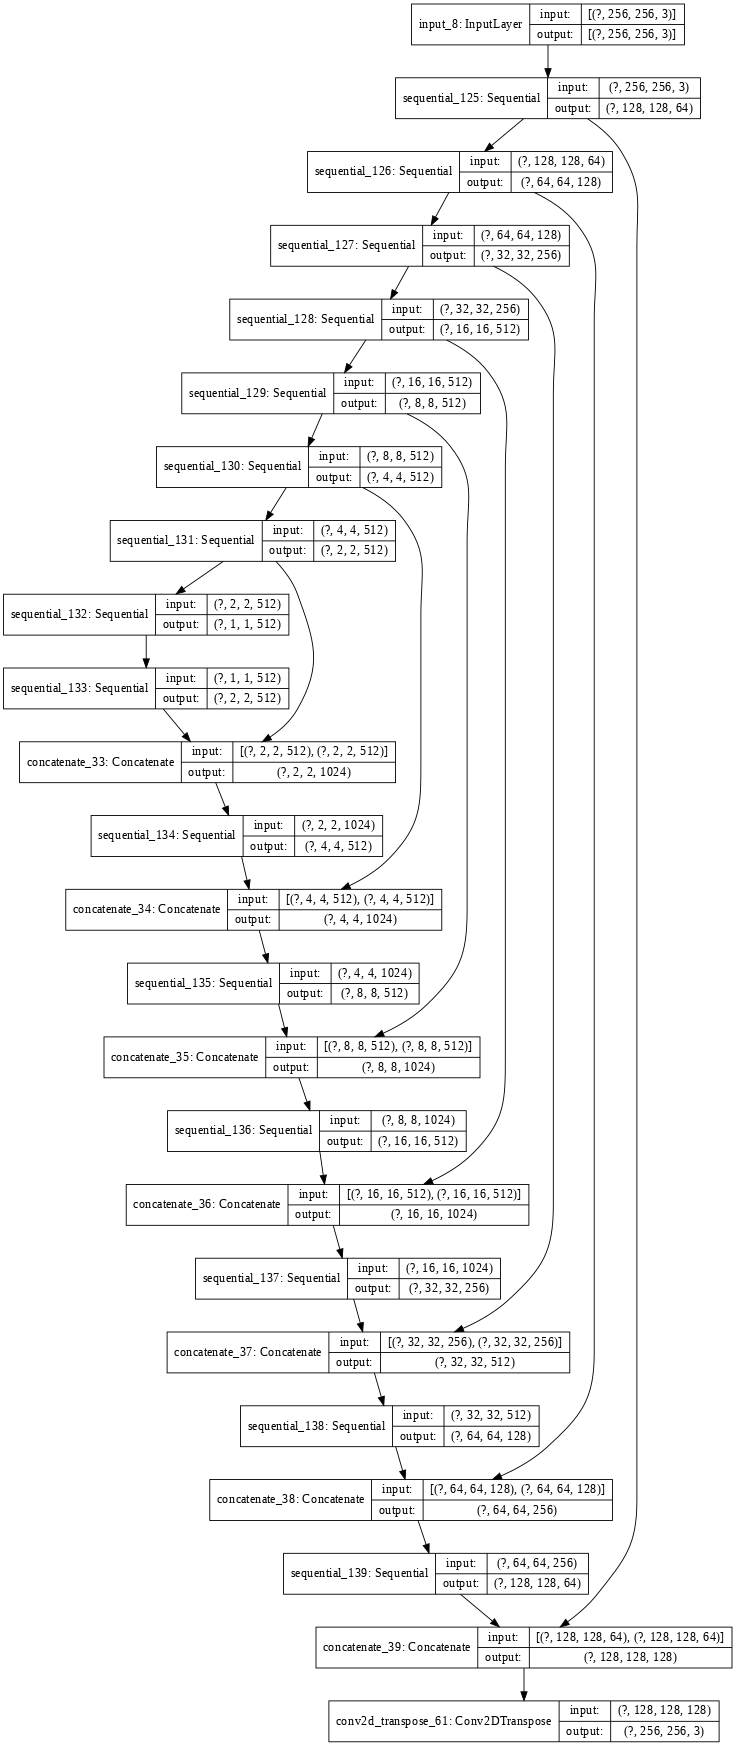

In [203]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True, dpi=64)

In [204]:
print(input.shape)
print(input[tf.newaxis, ...].shape)

(256, 256, 3)
(1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


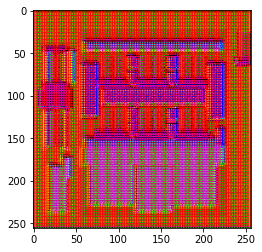

In [205]:
gen_op = generator(input[tf.newaxis, ...], training = False)
plt.imshow(gen_op[0, ...])

## **Generator Loss**

In [206]:
#acc to the paper the loss is sum of MAE (L1) loss and adversarial loss
#adv loss is Sigmoid CE with array of ones for the Generator
#L1 loss is weighted by lambda = 100

L1_lambda = 100

In [207]:
def gen_loss(disc_gen_out, gen_out, target):
  adv_loss = loss_fn(tf.ones_like(disc_gen_out), disc_gen_out)
  L1_loss = tf.reduce_mean(tf.abs(target - gen_out))

  total_loss_G = adv_loss + (L1_lambda * L1_loss)

  return total_loss_G, adv_loss, L1_loss


## **Build the Discriminator**

    - The Discriminator is a PatchGAN.
    - Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
    - The shape of the output after the last layer is (batch_size, 30, 30, 1)
    - Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
    - Discriminator receives 2 inputs.
        - Input image and the target image, which it should classify as real.
        - Input image and the generated image (output of generator), which it should classify as fake.
        - We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))


In [208]:
#Note that the discriminator will take in an image pair
#here 30x30 op is used to classify a 70x70 patch of the ip image

def Discriminator():
  w_init = tf.random_normal_initializer(0.0, 0.02)

  #here the input is common, refers to the preprocessed b/w image which is segmented
  input = tf.keras.layers.Input(shape = [256, 256, 3], name = "input_img")  
  target = tf.keras.layers.Input(shape = [256, 256, 3], name = "target_img")

  x = tf.keras.layers.concatenate([input, target])  #(batch, 256, 256, 6)

  d1 = downsample(64, 4, False)(x)  #(batch, 128, 128, 64)
  d2 = downsample(128, 4)(d1) #(batch, 64, 64, 128)
  d3 = downsample(256, 4)(d2) #(batch, 32, 32, 256)

  zero_1 = tf.keras.layers.ZeroPadding2D()(d3)  #(batch, 34, 34, 256) - THE NEXT LAYER USES VALID PADDING AND HENCE DIM DROPS
  conv_1 = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer=w_init, use_bias = False)(zero_1) #(batch, 31, 31, 512)

  bn1 = tf.keras.layers.BatchNormalization()(conv_1)
  leaky_relu = tf.keras.layers.LeakyReLU()(bn1)

  zero_2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  final_layer = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=w_init)(zero_2) # (batch, 30, 30, 1)

  return tf.keras.Model(inputs=[input, target], outputs=final_layer)


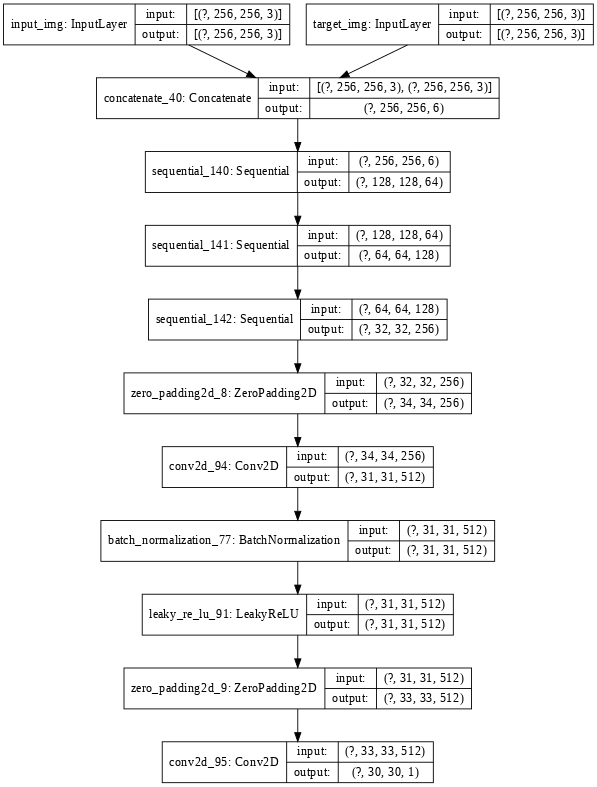

In [209]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True, dpi=64)

(1, 30, 30, 1)


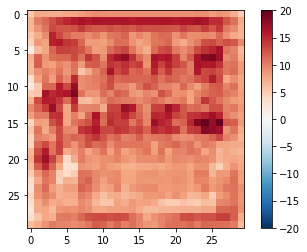

In [210]:
disc_op = discriminator([input[tf.newaxis,...], gen_op], training=False)
plt.imshow(disc_op[0,..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
print(disc_op.shape)
plt.colorbar()

## **Discriminator loss**

In [211]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [212]:
def discriminator_loss(disc_real_out, disc_gen_out):
  real_loss = loss_fn(tf.ones_like(disc_real_out), disc_real_out)

  generated_loss = loss_fn(tf.zeros_like(disc_gen_out), disc_gen_out)

  total_loss_D = real_loss + generated_loss 

  return total_loss_D

In [213]:
#use custom params, paper params not compulsary

generator_optimizer = tf.keras.optimizers.Adam(lr = 2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr = 2e-4, beta_1 = 0.5)

In [214]:
checkpoint_dir = './training_ckpts'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [215]:
def generate_images(model, test_input, target):
  prediction = model(test_input, training = True)
  plt.figure(figsize = (14, 14))

  display_list = [test_input[0], target[0], prediction[0]]
  title = ['Input Img', 'Ground Truth', 'Predicted Img']  #predicted image is the generator op here

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    #rescale between [0, 1] to plot
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  plt.show() 

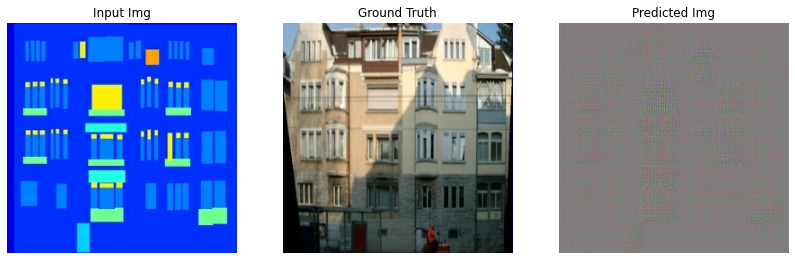

In [216]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)


In [217]:
pip install -q -U tensorboard==2.2.0


In [220]:
epochs = 150


#optional code segment

import datetime
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [228]:
@tf.function
def train_step(input_img, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #used to watch the trainable variables

    gen_op = generator(input_img, training = True)
    disc_real_op = discriminator([input_img, target], training = True)
    disc_gen_op = discriminator([input_img, gen_op], training = True)

    gen_total_loss, gen_adv_loss, gen_L1_loss = gen_loss(disc_gen_op, gen_op, target)
    disc_loss = discriminator_loss(disc_real_op, disc_gen_op)

  generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables) 
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_adv_loss', gen_adv_loss, step=epoch)
    tf.summary.scalar('gen_L1_loss', gen_L1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
  

The actual training loop:

    - Iterates over the number of epochs.
    - On each epoch it clears the display, and runs generate_images to show it's progress.
    - On each epoch it iterates over the training dataset, printing a '.' for each example.
    - It saves a checkpoint every 20 epochs.


In [229]:
def fit(train_data, epochs, test_data):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    #this usage of the test dataset every epoch is to view how to progress is
    for example_input, example_target in test_data.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_img, target) in train_data.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:  #space every 100 epochs
        print()
      train_step(input_img, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

  checkpoint.save(file_prefix = checkpoint_prefix)
  #checkpoint is saved after the final epoch too


In [230]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}


<IPython.core.display.Javascript object>

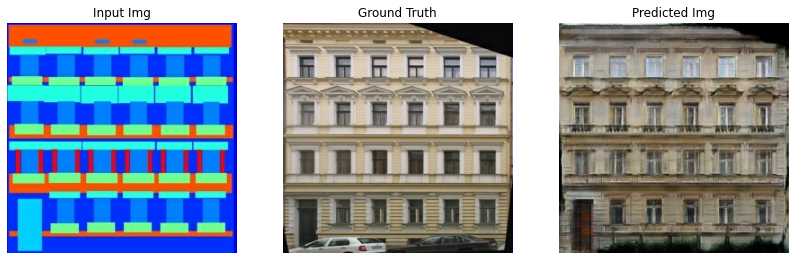

Epoch:  149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 150 is 70.98757195472717 sec



In [233]:
fit(train_dataset, epochs, test_dataset)

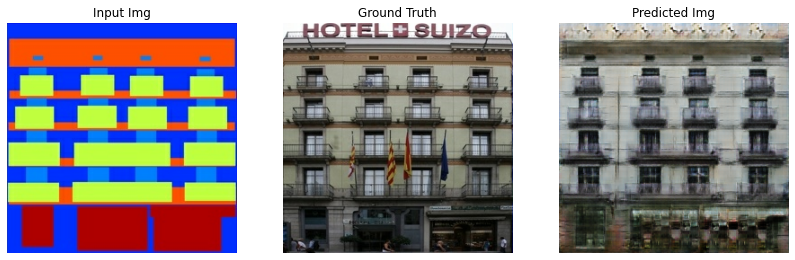

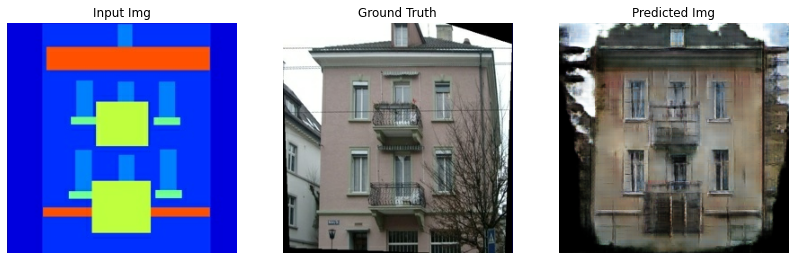

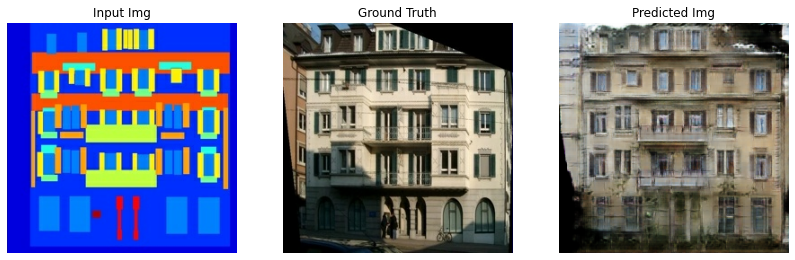

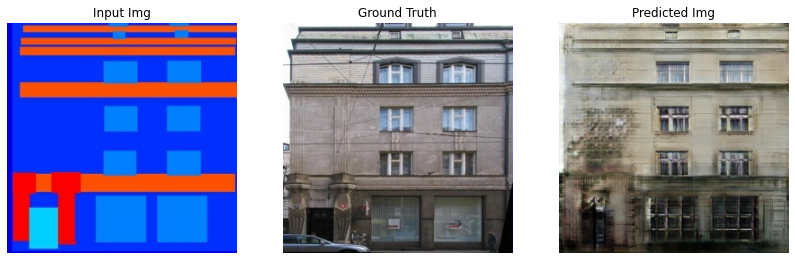

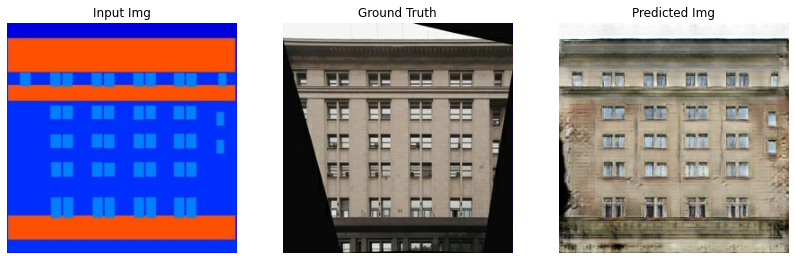

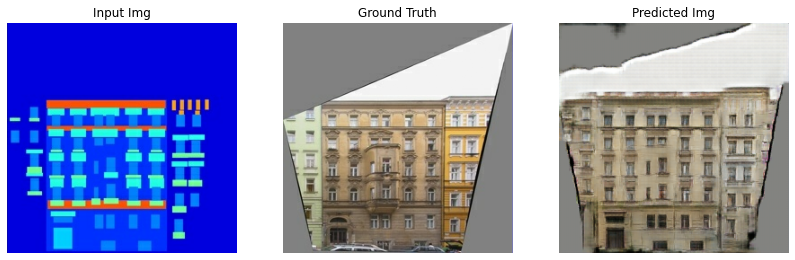

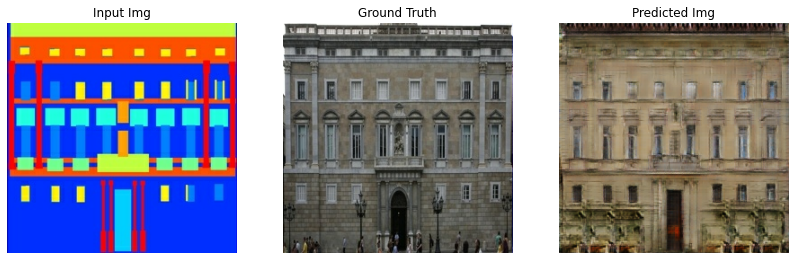

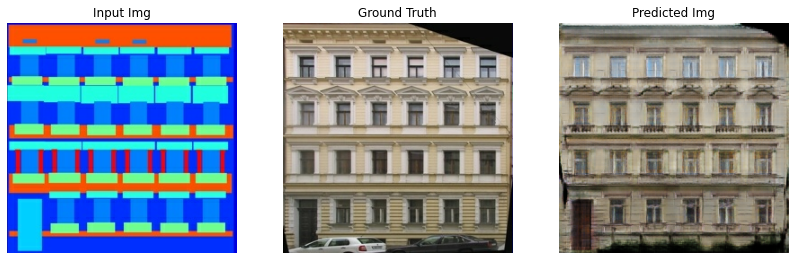

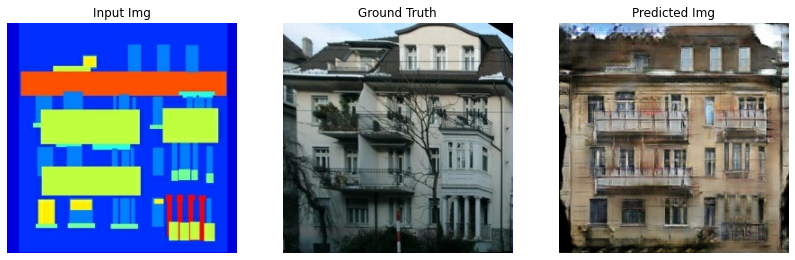

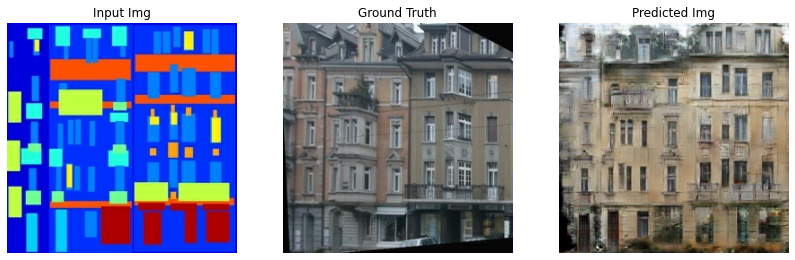

In [234]:
# Run the model on few egs from the test d_set

for input, target in test_dataset.take(10):
  generate_images(generator, input, target)


In [235]:
!zip -r /content/ckpts.zip /content/training_ckpts

  adding: content/training_ckpts/ (stored 0%)
  adding: content/training_ckpts/ckpt-7.index (deflated 79%)
  adding: content/training_ckpts/ckpt-5.data-00000-of-00002 (deflated 88%)
  adding: content/training_ckpts/ckpt-7.data-00001-of-00002 (deflated 18%)
  adding: content/training_ckpts/ckpt-4.data-00000-of-00002 (deflated 88%)
  adding: content/training_ckpts/ckpt-7.data-00000-of-00002 (deflated 88%)
  adding: content/training_ckpts/ckpt-2.data-00001-of-00002 (deflated 19%)
  adding: content/training_ckpts/ckpt-4.index (deflated 79%)
  adding: content/training_ckpts/ckpt-6.data-00001-of-00002 (deflated 18%)
  adding: content/training_ckpts/ckpt-1.index (deflated 79%)
  adding: content/training_ckpts/ckpt-6.index (deflated 79%)
  adding: content/training_ckpts/checkpoint (deflated 38%)
  adding: content/training_ckpts/ckpt-6.data-00000-of-00002 (deflated 88%)
  adding: content/training_ckpts/ckpt-3.data-00000-of-00002 (deflated 88%)
  adding: content/training_ckpts/ckpt-4.data-00001-

In [237]:
from google.colab import files
files.download("/content/ckpts.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>